In [115]:
import numpy as np
import os, sys, re
from math import *
import importlib as imp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tekal import *
from uitintegratie import *
import pandas as pd
import dill

import numpy.ma as ma
import fit_beta as fb
import fit_weibull as fw
from gumplot import *
import scipy.special as scs
import bisect
from IPython.lib.deepreload import reload as dreload
import inspect
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import gumplot as gplt

In [116]:
# Relevante herhaaltijden
Tretlist = [2,5,10,20,30,100,300,1250,3000,10000,30000,100000,400000]

<h3>Regressie HBV-to-SOBEK Rijn</h3>
Uit regressie is een relatie bepaald uit de HBV-(piek)afvoeren $Q_h$ en de bijbehorende Sobek (piek)afvoeren $Q_s$ als volgt (Henk vd Boogaard, <tt>regression_2018</tt>):
    $$Q_s\,=\,C\,+\,r_1Q_h\,+\,(r_2-r_1)\sigma_1\log\left(1+\exp\left(\frac{Q_h-\mu_1}{\sigma_1}\right)\right)$$
    $$\phantom{Q_s\,=\,C\,+\,r_1Q_h\,}+\,(r_3-r_2)\,\sigma_2\log\left(1+\exp\left(\frac{Q_h-\mu_2}{\sigma_2}\right)\right)$$    
    $$\phantom{Q_s\,=\,C\,+\,r_1Q_h\,}+\,(r_4-r_3)\,\sigma_3\log\left(1+\exp\left(\frac{Q_h-\mu_3}{\sigma_3}\right)\right)$$
    $$\phantom{Q_s\,=\,C\,+\,r_1Q_h\,}+\,(r_5-r_4)\,\sigma_4\log\left(1+\exp\left(\frac{Q_h-\mu_4}{\sigma_4}\right)\right)$$

In [117]:
import math   # Crucial import !!!
def regression_2018(x, fit_regr=False):
    c      = 342.254390
    r1     = 0.91577902
    mu1    = 14442.2780 #ORIG
    sigma1 = 307.118620
    r2     = 0.32752076
    mu2    = 18573.2200 #ORIG
    sigma2 = 2.71804449E-14
    r3     = 0.53632634 #ORIG
    mu3    = 21904.1250 #ORIG
    sigma3 = 136.807970  
    r4     = 0.21296795
    mu4    = 26177.6500 #ORIG
    sigma4 = 79.5476640
    r5     = 0.00000000
    if fit_regr == True:
        mu1    = 14800.0000
        mu2    = 17750.0000
        r3     = 0.75000000
        mu3    = 20000.0000
    
    x_ = []
    for value in x:
        z1 = (value-mu1)/sigma1
        z2 = (value-mu2)/sigma2
        z3 = (value-mu3)/sigma3
        z4 = (value-mu4)/sigma4
        
        a1 = (r1*value)
        a2 = ((r2-r1)*sigma1*np.log(1+np.exp(z1)))
        try:
            a3 = ((r3-r2)*sigma2*np.log(1+math.exp(z2)))
        except:
            a3 = ((r3-r2)*sigma2*z2)
        a4 = ((r4-r3)*sigma3*np.log(1+np.exp(z3)))
        a5 = ((r5-r4)*sigma4*np.log(1+np.exp(z4)))
        
        y = c + a1 + a2 + a3 + a4 + a5
        x_.append(y)

    return x_

In [118]:
# Tabel interpolatie
def interpolate(xx,yy,x,default=np.nan,fraction=-1):
    if x<xx[0] or x>xx[-1]:
        return default
    for i in range(len(xx)-1):
        if (x>=xx[i] and x<=xx[i+1]):
            if fraction<0.0:
                w=(x-xx[i])/(xx[i+1]-xx[i])   # use fraction=0.0 for yy[i] and fraction=1.0 for yy[i+1]
            else:
                w=fraction
            return (1.-w)*yy[i] + w*yy[i+1]

## Least-squares line fit
#def linfit(x,y):
#    nn = ma.count(x)
#    c = [(ma.sum(x*y)-ma.sum(x)*ma.sum(y)/nn)/(ma.sum(x*x)-ma.sum(x)*ma.sum(x)/nn)]
#    c.append((ma.sum(y)-c[0]*ma.sum(x))/nn)
#    return(c)

def linfit(xvec, yvec, wvec=None):
    if wvec is None:
        w = np.ones(len(xvec))
    else:
        w = wvec
    sw = ma.sum(w)
    sx = ma.sum(w*xvec)
    sy = ma.sum(w*yvec)
    sxx = ma.sum(w*xvec*xvec)
    sxy = ma.sum(w*xvec*yvec)   
    a = (sxy-sy*sx/sw)/(sxx-sx*sx/sw)
    b = (sy-a*sx)/sw
    return a,b

# lwrl based on a specified width
def lwrl(x,y,xtgt,width):
    pwr = 2.0
    xmax=np.max(x)
    xmin=np.min(x)
    ytgt = np.array([])
    for xx in xtgt:
        xxp = max(min(xx,xmax),xmin)
        mask = np.where(np.abs(x-xxp)<width)
        xsub = x[mask] - xxp
        ysub = y[mask]
        weights = (1.-(np.abs(xsub)/width)**pwr)**pwr
        a,b = linfit(xsub,ysub,weights)
        ytgt = np.append(ytgt,a*(xx-xxp) + b)
    return ytgt

def lower_exponential(x,a,b,lbnd,L):
    delta = (x-(L+lbnd-b)/a)
    if a*delta>0:
        y = a*x + b
    else:
        y = lbnd+L*np.exp(a/L*delta)
    return(y)

In [120]:
# outintegration with linear extrapolation in terms of the reduced gumbel variate
def outintegrateExtrap(parms, levels, distfun, n_extpt, n_intpt):
    # extrapolates the discharge curve beyond the highest point with npt points
    # the additional points are equally spaced on the F-axis between the highest F and 1
    # the additional parametersets are obtained by loglinear extrapolation from the 
    # highest npoints points in the data on the F-axis
    nparam = len(parms['distpar'][0])

    # fit the linear coefficients for each of the parameters
    list_a = []
    list_b = []
    for ipar in range(nparam):
        y = np.array([partuple[ipar] for partuple in parms['distpar']][-n_intpt:])
        F = np.array(parms['F'][-n_intpt:])
#       logt = np.log(1./(1.-F))     # fit linearly to the logarithm of the return period
#       a,b = linfit(sgv,y)
        sgv = -np.log(-np.log(F))    # fit linearly to the standarised gumbel variate
        a,b = linfit(sgv,y)
        list_a.append(a)
        list_b.append(b)

    # add a tuple of parameters and the F-value for points equally spaced between F_last and 1.0
    fhighest = parms['F'][-2]
    for ipt in range(n_extpt):
        ff_ipt = fhighest + (1.-fhighest)/(n_extpt+1)*(ipt+1)
#       logt_ipt = np.log(1./(1.-ff_ipt))
#       parms['distpar'].append(tuple([list_a[ipar]*logt_ipt+list_b[ipar] for ipar in range(nparam)]))
        sgv_ipt = -np.log(-np.log(ff_ipt))
        parms['distpar'].append(tuple([list_a[ipar]*sgv_ipt+list_b[ipar] for ipar in range(nparam)]))
        parms['F'] = np.append(parms['F'],ff_ipt)
    cdf = outintegrate(parms, levels, distfun)
    return cdf[cdf<1], levels[cdf<1]


<H3> Referentie werklijn en normale onzekerheid voor de Rijn, HBV-resultaten voor een optimal slice</H3>

In [119]:
# Lees de referentie werklijn voor de Rijn (2021)
with open('optimal_slice_mem6d_Fwet_500K_1951-2015_window61_part001-025_MAX.csv',"r") as fnin:
    qref = []
    minimum = 1000000.
    while True:
        line = fnin.readline()
        if not line:
            break
        syear, sqvalue = line.strip().split(',')
        try:
            year = int(syear)
            qvalue = float(sqvalue)
        except:
            continue
        bisect.insort(qref,qvalue)
nx = len(qref)
np_qref = np.array(qref)
np_sgv = -np.log(-np.log((np.array(list(range(nx)))+1.-0.3)/(nx+0.4)))

<H3> Onzekerheden (standaarddeviatie) behorende bij de werklijn: <br>
    Meteorologische (Jack-knife) en hydrologische (GLUE) onzekerheid gecombineerd</H3>

In [120]:
# Lees TEKAL file met Meteo onzekerheden
listTEKALBlocks("Final_FreqCurve_Rhine_HBV.tek")
# Lees TEKAL file (Henk vd Boogaard, met HBV onzekerheden)
UncMeteo = readTEKAL('Final_FreqCurve_Rhine_HBV.tek','BL01',skip=99)
tbl_mu_Meteo = UncMeteo[3]
tbl_sigma_Meteo = UncMeteo[5]

# Voeg de geinterpoleerde sigma's toe als onzekerheid
sigma_Meteo = []
for i in tqdm(list(range(np_qref.size))):
    sigma_Meteo.append(interpolate(tbl_mu_Meteo,tbl_sigma_Meteo,np_qref[i],default=10))
np_sigma_Meteo = np.array(sigma_Meteo)

rijn_new={'sgv':np_sgv,'mu':np_qref,'sigma':np_sigma_Meteo}

<H3> Log-lineaire extrapolatie van de werklijn + onzekerheid van 1250 jaar naar langere herhalingstijden.</h3>

Ook een transformatie naar SOBEK afvoeren d.m.v Regression2018 is uitgevoerd, zie afbeelding. Het is belangrijk dat de extrapolatie van de werklijn en onzekerheid vóór deze transformatie plaatsvindt.
</H3>

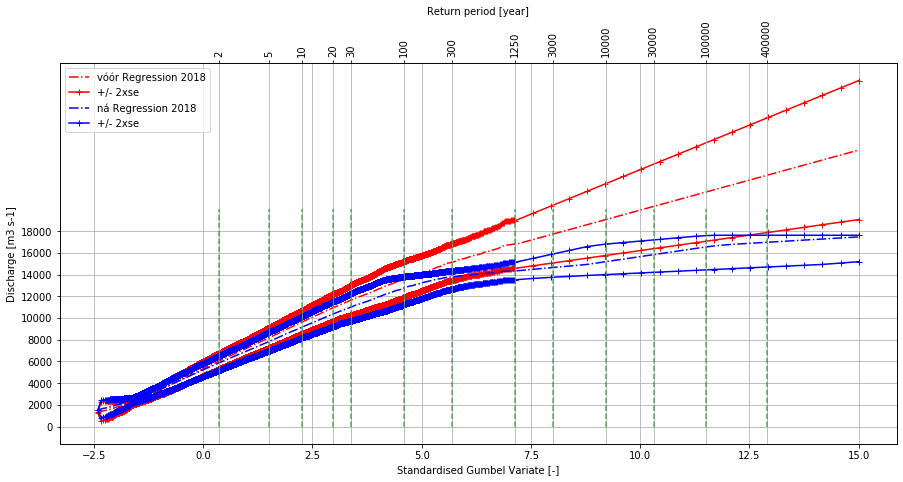

In [121]:
# Lineaire extrapolatie voor herhalingstijden boven de 1250 jaar
# van de 'HBV'- werklijn en de onzekerheid
Trmin = 1250 
Tr = 1./(1.-np.exp(-np.exp(-rijn_new['sgv'])))
mask = tuple([Tr>Trmin])
sgvmin = -np.log(-np.log(1.-1./Trmin))

a_mu, b_mu = linfit(rijn_new['sgv'][mask],rijn_new['mu'][mask])
a_sigma, b_sigma = linfit(rijn_new['sgv'][mask],rijn_new['sigma'][mask])

ymax = 20000 
yrange = 2000

sgvmax = 15
nsgv = 20
sgv_extrap = np.linspace(sgvmin,sgvmax,nsgv)
mu_extrap = sgv_extrap * a_mu + b_mu
sigma_extrap = sgv_extrap * a_sigma + b_sigma

mask = tuple([Tr<Trmin])
rijn_new_extrapolated = {}
rijn_new_extrapolated['sgv'] = np.concatenate((rijn_new['sgv'][mask], sgv_extrap))
rijn_new_extrapolated['mu'] = np.concatenate((rijn_new['mu'][mask], mu_extrap))
rijn_new_extrapolated['sigma'] = np.concatenate((rijn_new['sigma'][mask], sigma_extrap))

plt.plot(rijn_new_extrapolated['sgv'], rijn_new_extrapolated['mu'],'r-.',label='vóór Regression 2018')
plt.plot(rijn_new_extrapolated['sgv'], rijn_new_extrapolated['mu']+2*rijn_new_extrapolated['sigma'],'r+-', label='+/- 2xse')
plt.plot(rijn_new_extrapolated['sgv'], rijn_new_extrapolated['mu']-2*rijn_new_extrapolated['sigma'],'r+-')

plt.plot(rijn_new_extrapolated['sgv'], regression_2018(rijn_new_extrapolated['mu']),'b-.', label='ná Regression 2018')
plt.plot(rijn_new_extrapolated['sgv'], regression_2018(rijn_new_extrapolated['mu']+2*rijn_new_extrapolated['sigma']),'b+-', label='+/- 2xse')
plt.plot(rijn_new_extrapolated['sgv'], regression_2018(rijn_new_extrapolated['mu']-2*rijn_new_extrapolated['sigma']),'b+-')

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
gplt.add_gum_axis(Tretlist,ax,ymax,yrange)

<h3>Beschrijven van de hydraulische onzekerheid uit verstoorde SOBEK runs met de parameters van verdelingen</h3>

Voor elk van 50 events zijn 100 verschillende SOBEK simulaties gedraaid, elk met verstoorde parameters, 
om een maat te krijgen voor de onzekerheid in de hydraulische modellering (Latin-Hypercube). Voor elk van die 50 samples van elk 100 leden zijn hier de parameters geschat voor Beta, Normale en Uniforme verdeling. De Beta parameters zijn uiteindelijk niet gebruikt in deze berekening. Bij elke event hoort ook een referentie afvoer, dat is de SOBEK simulatie met onverstoorde parameters.

In [214]:
# Load ensembles into dictionaries
# Read the file into a dictionary, labelled by event->timeseries
datafile = 'read_Qmax_sums_results.csv'
sep = ';'
with open(datafile,"r") as fnin:
    line = fnin.readline().strip()
    colnames = re.sub(r'[^\x00-\x7F]','', line).split(sep)
    ensembles = { colname:[] for colname in colnames}
    while line:
        line = fnin.readline()
        linesplit = line.strip().split(sep)
        for i in range(len(linesplit)):
            if linesplit[i]:
                try:
                    ensembles[colnames[i]].append(float(linesplit[i].replace(',','.')))
                except:
                    ensembles[colnames[i]].append(linesplit[i])

# Select realizations from ensembles:
first_realization = 0
last_realization = 100
refnr = 113

label2nr = {}
rownames = ensembles['Scenario']
for i in range(len(rownames)):
    label2nr[rownames[i]] = i
selected = ['Sum%d'%dd for dd in range (first_realization,last_realization+1)]    # selected labels for realizations
selnr = [label2nr[rowname] for rowname in selected]

# Determine min, max, alpha, beta for each ensemble
irow_ref = label2nr['Sum%d'%refnr]
a = np.array([])
b = np.array([])
alpha = np.array([])
beta = np.array([])
qref = np.array([])
mu = np.array([])
sigma = np.array([])
minvalue = np.array([])
maxvalue = np.array([])

a_2se = np.array([])
b_2se = np.array([])
alpha_2se = np.array([])
beta_2se = np.array([])
c0 = colnames.pop(0)
for icol in range(1,len(colnames)): 
    sample=np.array([ensembles[colnames[icol]][i] for i in selnr])
    est,var = fb.fitBetaMomentsJack(sample)
    
    alpha = np.append(alpha,est[0])
    beta = np.append(beta,est[1])
    a = np.append(a,est[2])
    b = np.append(b,est[3])
    alpha_2se = np.append(alpha,var[2])
    beta_2se = np.append(beta,var[3])
    a_2se = np.append(a,var[0])
    b_2se = np.append(b,var[1])
    qref = np.append(qref,ensembles[colnames[icol]][irow_ref])
    mu = np.append(mu,np.mean(sample))
    sigma = np.append(sigma,np.std(sample))
    minvalue = np.append(minvalue,np.min(sample))
    maxvalue = np.append(maxvalue,np.max(sample))
    
#sys.stdout.write("%11s    %8s %8s       %8s    %8s       %8s  %8s    %s\n"%('Ref','alpha','beta','A', 'B', 'mu', 'sigma', 'Label'))
#for i in range(len(qref)):
#   sys.stdout.write("%8.5f    %8.5f %8.5f    %8.5f %8.5f    %8.5f %8.5f    %s\n"%(qref[i],alpha[i],beta[i],a[i],b[i],mu[i],sigma[i],colnames[i]))    

sys.stdout.write("%11s    %8s %8s       %8s    %8s       %8s  %8s    %s\n"%('Ref','alpha','beta','A', 'B', 'min', 'max', 'Label'))
for i in range(len(qref)):
    sys.stdout.write("%8.5f    %8.5f %8.5f    %8.5f %8.5f    %8.5f %8.5f    %s\n"%(qref[i],alpha[i],beta[i],a[i],b[i],minvalue[i],maxvalue[i],colnames[i]))        

        Ref       alpha     beta              A           B            min       max    Label
14902.15723     2.62803  1.50101    13412.81502 15745.20368    13584.42871 15562.20898    b24000
15286.16699     1.77462  1.56257    13709.32447 16841.72014    13718.41309 16661.36719    maxQ_14199_maxV_28.8_year_3345
13351.64551     2.03466  1.06650    11795.17034 14115.33281    11924.44336 14031.70215    maxQ_14210_maxV_18.1_year_2288
14307.43555     1.61699  1.45716    12767.70517 15810.41097    12881.73926 15571.75781    maxQ_14256_maxV_11.5_year_3236
14193.20605     1.33763  1.48444    13180.73558 15434.22470    13077.18164 15190.62988    maxQ_14434_maxV_14.1_year_3126
14482.79395     1.45828  1.46577    13095.98703 15817.19115    13046.71289 15653.83301    maxQ_14450_maxV_23.4_year_3048
15096.23535     1.54703  1.60232    13823.27269 16404.51866    13835.35742 16324.05273    maxQ_14567_maxV_18.9_year_7445
14179.44336     1.64708  1.55112    12614.64039 15610.31952    12757.94238 15439.61

<h3>Beschrijven van de parameters als lineaire functies van de referentie afvoer</h3>

De boven afgeleide parameters van verdelingen voor elke event en bijbehorende referentie afvoer vormen een onregelmatig geheel. Om toch bruikbare parameters te krijgen voor een willekeurige referentie afvoer zijn lineaire verbanden gefit. 

In [215]:
# linear fits on the location parameters of the Beta distribution A and B
c_a = linfit(qref,a)
c_b = linfit(qref,b)

# linear fits on the shape parameters alpha and beta
c_alpha = linfit(qref,alpha)
c_beta = linfit(qref,beta)

# linear fits on the normal parameters mu and sigma
c_mu = linfit(qref,mu)
c_sigma = linfit(qref,sigma)

# linear fits on the uniform parameters min and max
c_min = linfit(qref,minvalue)
c_max = linfit(qref,maxvalue)

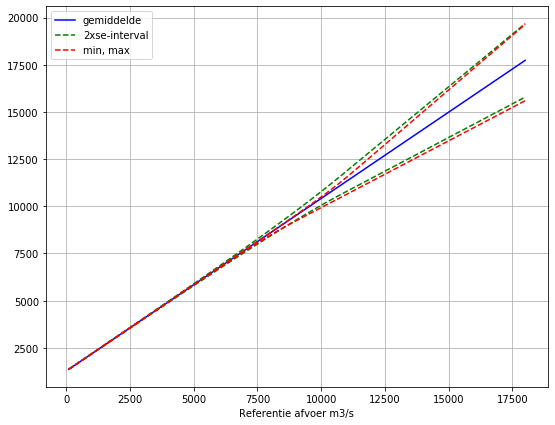

In [312]:
# gebaseerd op de uit LHS (SOBEK) exprimenten gevonden hydraulische onzekerheid
# geeft the verwachting en standaard deviatie van de SOBEK afvoer, als functie van de onverstoorde referentie afvoer
def hydraulic_uncertainty_uniform(qref):
    maxval_array = []
    minval_array = []
    for qr in qref:
        minval_array.append(-lower_exponential(qr,(c_mu[0]-c_min[0]), (c_mu[1]-c_min[1]),0,250)
                           + c_mu[0]*qr + c_mu[1])
        maxval_array.append(lower_exponential(qr,(c_max[0]-c_mu[0]), (c_max[1]-c_mu[1]),0,250)
                           + c_mu[0]*qr + c_mu[1])
    return (np.array(minval_array),np.array(maxval_array))
    

## gebaseerd op de uit LHS (SOBEK) exprimenten gevonden hydraulische onzekerheid
## geeft the verwachting en standaard deviatie van de SOBEK afvoer, als functie van de onverstoorde referentie afvoer
def hydraulic_uncertainty_normal(qref):
    mu_array = []
    sgm_array = []
    for qr in qref:
        sgm_array.append(lower_exponential(qr,c_sigma[0],c_sigma[1],0,250))
        mu_array.append(lower_exponential(qr,c_mu[0],c_mu[1],0,10))
    return (np.array(mu_array),np.array(sgm_array))
    
# Plot betrouwbaarheidsband voor de hydraulische onzekerheid symmetrisch (LHS experiment)
qq = np.linspace(100,18000,1000)
qq_mu, qq_sgm = hydraulic_uncertainty_normal(qq)
plt.plot (qq,qq_mu,'b-',label='gemiddelde')
plt.plot (qq,qq_mu+2*qq_sgm,'g--',label='2xse-interval')
plt.plot (qq,qq_mu-2*qq_sgm,'g--')

qq_minval, qq_maxval = hydraulic_uncertainty_uniform(qq)
plt.plot (qq,qq_minval,'r--',label='min, max')
plt.plot (qq,qq_maxval,'r--')

ax=plt.gca()
xlbl=ax.set_xlabel('Referentie afvoer m3/s')

fig=plt.gcf()
fig.set_size_inches(9,7)
lgnd=ax.legend(loc="upper left")
xg = ax.grid()

Hierboven een weergave van twee vormen van hydraulische onzekerheid: het minimum-maximum interval (uit grootste en kleinste waarde) <br>en het 2xse-interval. <br>
NB. <i>Alléén voor de normale verdeling is het 2xse-interval ongeveer gelijk aan het tweezijdig 95% interval, hier dus duidelijk niet. </i>

 <h3>Simulatie van hydrologische en hydraulische onzekerheid</h3>
 De combinatie van onzekerhed door simulatie (opeenvolgende trekkingen). <br>
 De gevolgde werkwijze voor elke standardised gumbel variate $y$, oftewel voor elke herhalingstijd in een set: 
 <ul>   
 <li>Interpoleer uit de HBV-gebaseerde extremenplot de bijbehorende waarde van de afvoer én de standaard deviatie
 <li>  Jackknife + hydrologsche model onzekerheid -> $\mu_{hbv}(y)$, $\sigma_{hbv}(y)$
 <li>  Trek met deze parameters een normaal sample
 <li>  Voor élke $q_{hbv}$ uit dat sample:
 <ul>   
     <li> Transformeer naar een 'SOBEK' waarde $q_{hbv} \rightarrow q_{sbk}$ met <tt>Regression2018</tt>
   <li> Als functie van deze $q_{sbk}$, haal de $\mu_{sbk}$ en $\sigma_{sbk}$ in het geval van een normale benadering, of de min en max in het geval van de uniforme benadering.<br> Hiervoor wordt de lineaire fit gebruikt, maar wel met restricties: $\sigma_{sbk}\ge0$ en ${\rm min}\le\mu_{sbk}\le{\rm max}$.
   <li>Trek met de parameters een nieuwe waarde $q_{sbk}'$<br>
     (deze waarde bevat het nu effect van de hydaulische onzekerheid)
 </ul> 
 <li> Uit het sample van $q_{sbk}'$ waarden, fit een 3-parameter weibull verdeling
 </ul>

In [299]:
# Deze functie doet voor elke standardised gumbel variate y in de set stdgumvars het volgende: 
# * Interpoleert uit de HBV-gebaseerde extremenplot de bijbehorende waarde van de afvoer én de standaard deviatie
#   Jackknife + hydrologsche model onzekerheid -> mu_hbv, sigma_hbv
# * Trekt met de parameters mu_hbv en sigma_hbv een normaal sample
# * Voor élke q_hbv uit dat sample:
#   * Transformeer naar q_sobek
#   * als functie van deze q_sbk, haal de mu_sbk, sigma_sbk
#   * Trek met de parameters mu_sbk en sigma_sbk een nieuwe waarde q_sbk2
#     (deze waarde bevat het nu effect van de hydaulische onzekerheid)
# * Uit het sample van q_sbk2 waarden, fit een 3-parameter weibull verdeling

imp.reload(fw)

def sample_sbk_uniform(qsbk, sample_size):
    qq_minval, qq_maxval = hydraulic_uncertainty_uniform([qsbk])               # Bepaal normal parameters
    return np.random.uniform(low=qq_minval, high=qq_maxval, size=sample_size)   # trek hieruit een Normaal verdeelde sample

def sample_sbk_normal(qsbk, sample_size):
    qq_mu, qq_sgm = hydraulic_uncertainty_normal([qsbk])      # Bepaal normal parameters
    return np.random.normal(qq_mu, qq_sgm, sample_size)       # trek hieruit een Normaal verdeelde sample

def effective_sample_cascade(mu_hbv, sigma_hbv, sample_size, sample_func):
    # return the simulated sample of sobek discharges given the normal mu and sigma of the HBV-discharges only
    # this step takes into account the hydraulic uncertainty through the Beta distribution
    q_hbv = np.random.normal(mu_hbv,sigma_hbv,sample_size)# Trek een normaal sample met N(mu,sigma)
    q_sbk=regression_2018(q_hbv)                          # Transformeer dit sample met regression2018
    q_sbk0=regression_2018([mu_hbv])[0]                   # Transformeer gemiddelde met regression2018
    q_sbk2 = np.array([sample_func(qq,1)[0] for qq in q_sbk])
    return (q_sbk2)

def effective_weibull_random(stdgumvars,rijndata,sample_size,sample_func):
#   sample_size = 10000
    mu = rijndata['mu']
    sgv = rijndata['sgv']
    sgm = rijndata['sigma']
    qsamples = []
    mu_sbk = []
    for y in stdgumvars:
        qhbv_mu = interpolate(sgv,mu,y)               # verwachtingswaarde uit HBV voor de gegeven herhalingstijd
        qhbv_sigma = interpolate(sgv,sgm,y)           # stddev uit HBV voor de gegeven herhalingstijd
        qsample = effective_sample_cascade(qhbv_mu, qhbv_sigma, sample_size, sample_func)
        mu_sbk.append(regression_2018([qhbv_mu])[0])  # Transformeer de mu(hbv) om de werklijn te krijgen        
        qsamples.append(qsample)
       
    estimates = []
    for qs in qsamples:
        estimate = fw.fitWeibullLMoments(qs)
        # correct Location parameter C for the mean of the distribution    
        estimates.append(estimate)
    return (estimates, mu_sbk, qsamples)

Hier worden de simulaties aangeroepen voor zowel uiforme als normale hydraulische onzekerheid.<br>
Vervolgens is het 95%-betrouwbaarheids interval bepaald door de Weibull quantiel functie.

In [316]:
sgvvals = np.concatenate((np.arange(-2,3.,step=0.2),np.arange(3.,15,step=0.5)))
size = 50000
estimates_uni, mu_sbk_uni, qsamples_uni = effective_weibull_random(sgvvals, rijn_new_extrapolated, size, sample_sbk_uniform)
q025_weibull_uniform = np.array([fw.qfunweibull(est[0],est[1],est[2],0.025) for est in estimates_uni])
q975_weibull_uniform = np.array([fw.qfunweibull(est[0],est[1],est[2],0.975) for est in estimates_uni])

estimates_norm, mu_sbk_norm, qsamples_norm = effective_weibull_random(sgvvals, rijn_new_extrapolated, size, sample_sbk_normal)
q025_weibull_normal = np.array([fw.qfunweibull(est[0],est[1],est[2],0.025) for est in estimates_norm])
q975_weibull_normal = np.array([fw.qfunweibull(est[0],est[1],est[2],0.975) for est in estimates_norm])

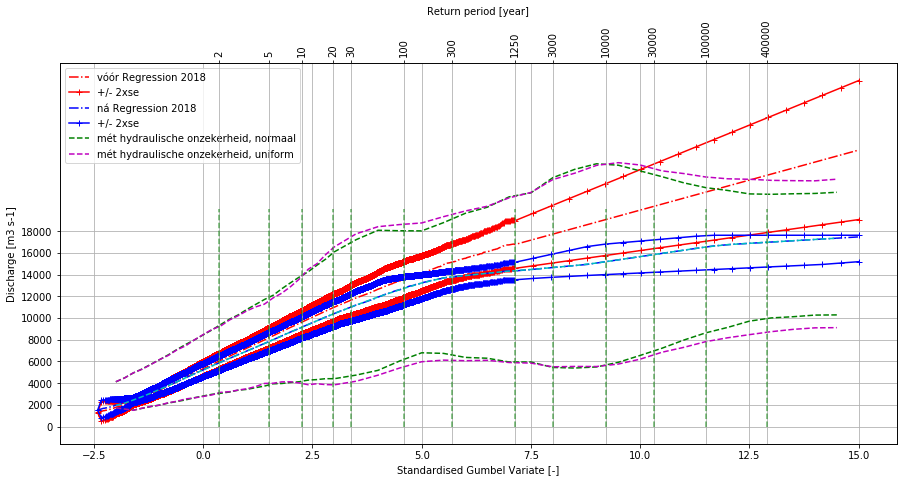

In [315]:
ymax = 20000 
yrange = 2000

plt.plot(rijn_new_extrapolated['sgv'], rijn_new_extrapolated['mu'],'r-.',label='vóór Regression 2018')
plt.plot(rijn_new_extrapolated['sgv'], rijn_new_extrapolated['mu']+2*rijn_new_extrapolated['sigma'],'r+-', label='+/- 2xse')
plt.plot(rijn_new_extrapolated['sgv'], rijn_new_extrapolated['mu']-2*rijn_new_extrapolated['sigma'],'r+-')

plt.plot(rijn_new_extrapolated['sgv'], regression_2018(rijn_new_extrapolated['mu']),'b-.', label='ná Regression 2018')
plt.plot(rijn_new_extrapolated['sgv'], regression_2018(rijn_new_extrapolated['mu']+2*rijn_new_extrapolated['sigma']),'b+-', label='+/- 2xse')
plt.plot(rijn_new_extrapolated['sgv'], regression_2018(rijn_new_extrapolated['mu']-2*rijn_new_extrapolated['sigma']),'b+-')

plt.plot(sgvvals, q025_weibull_normal,'g--', label='mét hydraulische onzekerheid, normaal')
plt.plot(sgvvals, q975_weibull_normal,'g--')

plt.plot(sgvvals, q025_weibull_uniform,'m--', label='mét hydraulische onzekerheid, uniform')
plt.plot(sgvvals, q975_weibull_uniform,'m--')
plt.plot(sgvvals, mu_sbk,'c--')

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
gplt.add_gum_axis(Tretlist,ax,ymax,yrange)

In [364]:
# HydraRing parameters moeten gegeven zijn als functie van de referntie(=werklijn) afvoer, in dit geval het gemiddelde
# In de volgorde schaal, vorm, locatie voor de Weibull verdeling
# De referentie afvoer moet ervan zijn afgetrokken, zodat die door HydraRing kan worden bijgeteld

fpar = open('weibull_parameters','w')
fpar.write("%10s, %10s, %10s, %10s\n"%('Qref', 'distpar1', 'distpar2', 'distpar3'))
sys.stdout.write("%10s, %10s, %10s, %10s\n"%('Qref', 'distpar1', 'distpar2', 'distpar3'))

nskip = 1
i = 0
for (mu_s,est) in zip(mu_sbk,estimates_norm):
    i = i + 1
    if (i%(nskip+1)==0) or (i==np.size(mu_s)-1) or i==1:
        sys.stdout.write("%10.3f, %10.3f, %10.3f, %10.3f\n"%(mu_s,est[2],est[1],est[0]-mu_s))
        fpar.write("%10.3f, %10.3f, %10.3f, %10.3f\n"%(mu_s,est[2],est[1],est[0]-mu_s))
fpar.close()

      Qref,   distpar1,   distpar2,   distpar3
  1954.798,    925.222,      3.533,    264.710
  2152.989,    695.469,      3.565,    453.471
  2745.476,    469.257,      3.514,    606.820
  3410.284,    631.948,      3.546,    403.956
  4125.872,    828.163,      3.466,    166.574
  4857.682,    926.700,      3.505,     16.053
  5578.569,   1036.267,      3.480,   -143.602
  6277.629,   1095.497,      3.444,   -255.073
  6958.227,   1175.332,      3.436,   -382.841
  7647.688,   1325.157,      3.424,   -575.769
  8350.280,   1447.505,      3.361,   -747.885
  9045.540,   1487.223,      3.221,   -835.487
  9732.933,   1641.452,      3.119,  -1034.658
 10404.027,   1743.937,      3.001,  -1179.582
 11927.321,   2225.853,      2.922,  -1745.498
 13223.494,   2685.541,      3.782,  -2372.513
 13905.053,   2266.632,      3.477,  -1995.704
 14317.510,   2226.487,      3.126,  -1946.837
 14642.090,   2290.427,      2.781,  -1983.282
 15057.419,   2458.185,      2.490,  -2104.618
 15650.658,  

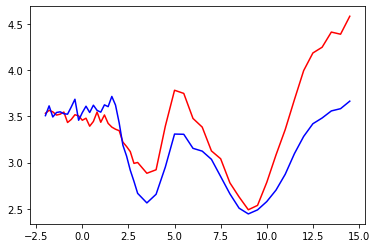

In [323]:
plt.plot(sgvvals,np.array([est[1] for est in estimates_norm]),'r-')
plt.plot(sgvvals,np.array([est[1] for est in estimates_uni]),'b-')

17347.961619544694


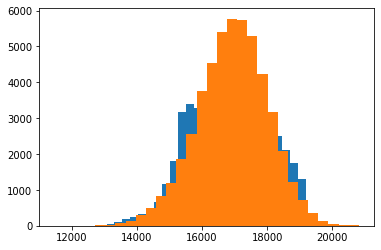

In [345]:
plt.hist(qsamples_uni[48],30)
plt.hist(qsamples_norm[48],30)
print(mu_sbk[48])

In [305]:
# Lees de observaties(blokmaxima, toestand 2004) - NOT USED
with open("observations\\Lobith_HR2006_AM.csv","r") as fnin:
    qhis = []
    while True:
        line = fnin.readline()
        if not line:
            break
        try:
            ss = line.split(';')
            year = int(ss[0])
            qmax_1977 = float(ss[1])
            qmax_2004 = float(ss[2])
            bisect.insort(qhis,qmax_2004)
        except:
            pass
nxhis = len(qhis)
rijn_obs = {}
rijn_obs['sgv'] = -np.log(-np.log((np.array(list(range(nxhis)))+1.-0.3)/(nxhis+0.4)))
rijn_obs['mu'] = np.array(qhis)

In [306]:
# Lees de observaties(blokmaxima, toestand 2004)
with open("observations\\Historical TQ_1901_2000_K.csv","r") as fnin:
    qhis = []
    years = []
    months = []
    while True:
        line = fnin.readline()
        if not line:
            break
        try:
            ss = line.split(',')
            year = int(ss[0][0:4])
            month= int(ss[0][4:6])
            q = float(ss[8])
            years.append(year)
            months.append(month)
            qhis.append(q)
        except:
            pass
        
df = pd.DataFrame([years,months,qhis]).T
df.columns = ['Y','M','Q']
df['HY'] = df['Y']
df['HY'][df['M'] > 9] =  df['HY']+1
df_max = np.sort(df.groupby(df['HY']).max()['Q'])

nxhis = len(df_max)
rijn_obs = {}
rijn_obs['sgv'] = -np.log(-np.log((np.array(list(range(nxhis)))+1.-0.3)/(nxhis+0.4)))
rijn_obs['mu'] = np.array(df_max)


In [14]:
#apply weissman extrapolation to GRADE'21
def weissman(xi,**kwargs):
    if 'tretlist' in kwargs:
        fx = 1./kwargs['tretlist']
    elif 'flist' in kwargs:
        fx = 1.-kwargs['flist']
    elif 'fxlist' in kwargs:
        fx = kwargs['fxlist']
    else:
        return
    nx = len(xi)
    if 'k' in kwargs: 
        k = kwargs['k']
        sgvth = -np.log(-np.log((nx-k+1-0.3)/(nx+0.4)))
    elif 'fxth' in kwargs: 
        k = int(0.3 + (nx + 0.4)*(1.-kwargs['fxth']))
        sgvth = -np.log(-np.log(1.-kwargs['fxth']))
    else:        # default values
        k = 10
        sgvth = -np.log(-np.log(nx-k+1-0.3)/(nx+0.4))
        
        
    xs = np.array(xi[-k:])[~np.isnan(xi[-k:])]
    sigma_hat = np.mean(xs)-xi[-k]
    sgvi = -np.log(-np.log((np.array(list(range(nx)))+1-0.3)/(nx+0.4)))
    sgvo = -np.log(-np.log(1.0 - fx))
    
    weissman_values = xi[-k] + sigma_hat * np.log(1./fx*(k/nx))
    interpol_values = np.array([interpolate(sgvi,xi,sgv) for sgv in sgvo])
    retvals = np.append(interpol_values[sgvo<sgvth], weissman_values[sgvo>sgvth])
    return retvals 

rijn_new['mu_sbk'] = regression_2018(rijn_new['mu'])
rijn_new['sgv_select'] = [-np.log(-np.log(1.-1./Tr)) for Tr in Tretlist]
rijn_new['mu_sbk_select'] = weissman(rijn_new['mu_sbk'],tretlist=np.array(Tretlist),k=20)


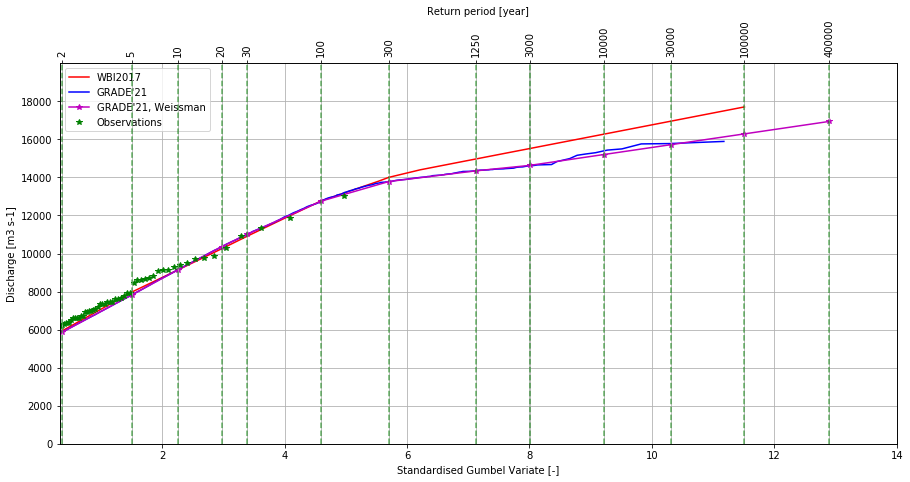

In [15]:
#plot oud versus observations
fig, ax = plt.subplots(1,1)
ax.set_xlim(0.325,14)
ymax = 20000 
yrange = 2000
ax.set_ylim(0,ymax)

ax.plot(rijn_old['sgv'],rijn_old['mu'],'r-',label="WBI2017")
ax.plot(rijn_new['sgv'],rijn_new['mu_sbk'],'b-',label="GRADE'21")
ax.plot(rijn_new['sgv_select'],rijn_new['mu_sbk_select'],'m-*',label="GRADE'21, Weissman")
ax.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observations")

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax,ymax,yrange)
plt.savefig('plots//plot_01.png', dpi=150, bbox_inches='tight')


In [16]:
# Genereer een tabel voor gezette herhalingstijden
table = {'Herhaaltijd':Tretlist}
qmax_old = []
qmax_new = []
table={'Herhaaltijd':Tretlist}
for tr in Tretlist:
    qmax_old.append(interpolate(rijn_old['sgv'],rijn_old['mu'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    qmax_new.append(interpolate(rijn_new['sgv_select'],rijn_new['mu_sbk_select'],-np.log(-np.log(1.-1./tr)),default=np.nan))
table['Qmax oud']=np.round(np.array(qmax_old)*100)/100.
table['Qmax nieuw']=np.round(np.array(qmax_new)*100)/100.
pd.DataFrame(table)


,Herhaaltijd,Qmax oud,Qmax nieuw
0,2,5940.0,5866.31
1,5,7970.0,7821.39
2,10,9129.0,9132.63
3,20,10250.0,10361.42
4,30,10905.0,11009.60
5,100,12773.0,12758.19
6,300,14004.0,13784.86
7,1250,14974.0,14348.52
8,3000,15520.0,14633.46
9,10000,16271.0,15202.08


In [17]:
# Hulp routines voor de uitintegratie
def normal_cdf(x,parms):
    mu = parms[0]
    sigma = parms[1]
    return (1.0 + erf((x-mu) / sigma / sqrt(2.0))) / 2.0

def normal_pdf(x,parms):
    mu = parms[0]
    sigma = parms[1]
    return exp(-0.5*((x-mu)/2./sigma)**2)/(sigma*(2*pi)**0.5)

In [18]:
# Voer een uitintegratie uit voor de oude resultaten
nx_old = len(rijn_old['sgv'])
rijn_old['uitintegratie']={}
rijn_parms = {'distpar':[(rijn_old['mu'][i] ,rijn_old['sigma'][i]) for i in range(nx_old)],
              'F':np.exp(-np.exp(-rijn_old['sgv']))}
rijn_old['uitintegratie']['levels'] = np.array(list(range(5000,20000,100)))
rijn_cdf = outintegrate(rijn_parms, rijn_old['uitintegratie']['levels'], normal_cdf)
rijn_old['uitintegratie']['sgv'] = -np.log(-np.log(rijn_cdf))

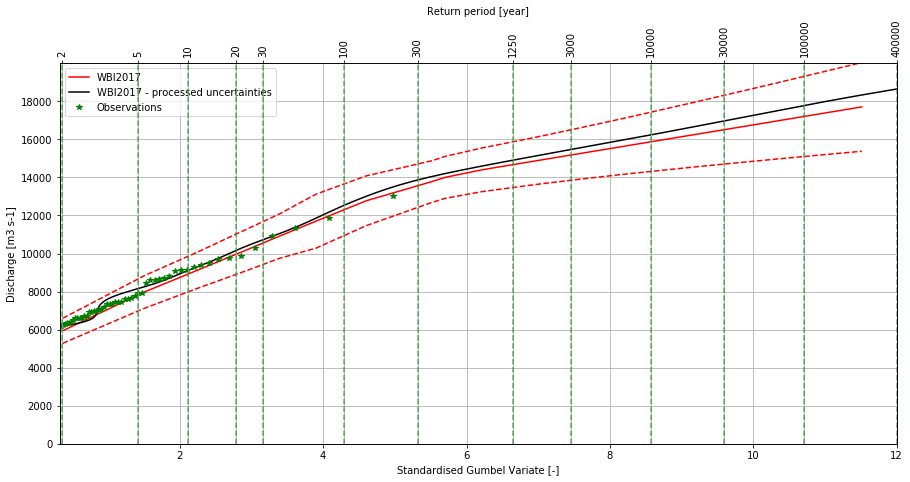

In [19]:
#plot oud versus observations met 
fig, ax = plt.subplots(1,1)
ax.set_xlim(0.325,12)
ymax = 20000 
yrange = 2000
ax.set_ylim(0,ymax)

ax.plot(rijn_old['sgv'],rijn_old['mu'],'r-',label="WBI2017")
ax.plot(rijn_old['sgv'],rijn_old['mu']+1.96*rijn_old['sigma'],'r--')
ax.plot(rijn_old['sgv'],rijn_old['mu']-1.96*rijn_old['sigma'],'r--')
ax.plot(rijn_old['uitintegratie']['sgv'],rijn_old['uitintegratie']['levels'],'k-',label="WBI2017 - processed uncertainties")
ax.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observations")

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax,ymax,yrange)
plt.savefig('plots//plot_02.png', dpi=150, bbox_inches='tight')

In [58]:
# Voer uitintegratie uit met de nieuwe estimates
# Voer een uitintegratie uit voor de nieuwe resultaten
def cdfbeta(y,parms):
    return fb.beta_forward(parms[0],parms[1],parms[2],parms[3],y)

rijn_new['uitintegratie'] = {}
np_yy = np.array([est[0] for est in estimates])
rijn_parms_new = {'distpar' : [est[1] for est in estimates],
                  'F' : np.exp(-np.exp(-np_yy))}
rijn_new['uitintegratie'] = {}
rijn_new['uitintegratie']['levels'] = np.array(list(range(6000,21000,100)))
rijn_cdf_new = outintegrate(rijn_parms_new, rijn_new['uitintegratie']['levels'] , cdfbeta)
rijn_new['uitintegratie']['sgv'] = -np.log(-np.log(rijn_cdf_new))

# Maak door interpolatie een subset en voer hiermee de uitintegratie uit
distpar_select=[]
F_select=[]
for Tr in Tretlist:
    sgv = -np.log(-np.log(1.-1./Tr))
    alpha = interpolate(sgv_i,alpha_i,sgv)
    beta = interpolate(sgv_i,beta_i,sgv)
    AA = interpolate(sgv_i,AA_i,sgv)
    BB = interpolate(sgv_i,BB_i,sgv)
    if not any(np.isnan([alpha,beta,AA,BB])):
        F_select.append(1.-1./Tr)
        distpar_select.append([alpha,beta,AA,BB])
rijn_parms_new2 = {'distpar' : distpar_select,
                  'F' : F_select}
rijn_new['uitintegratie2'] = {}
rijn_new['uitintegratie2']['levels'] = np.array(list(range(6000,21000,100)))
rijn_cdf_new2 = outintegrate(rijn_parms_new2, rijn_new['uitintegratie2']['levels'] , cdfbeta)
rijn_new['uitintegratie2']['sgv'] = -np.log(-np.log(rijn_cdf_new2)) 

# Corrigeer de locatie parameters NA interpolatie en voer weer uitintegratie uit
distpar_select=[]
F_select=[]
mean_i = [alpha/(alpha+beta)*(BB-AA)+AA for alpha, beta, AA, BB in zip(alpha_i,beta_i,AA_i,BB_i)]
for Tr in Tretlist:
    sgv = -np.log(-np.log(1.-1./Tr))
    alpha = interpolate(sgv_i,alpha_i,sgv)
    beta = interpolate(sgv_i,beta_i,sgv)
    mean = interpolate(sgv_i,mean_i,sgv)        # interpolated expectation derived from parameters
    AA = interpolate(sgv_i,AA_i,sgv)
    BB = interpolate(sgv_i,BB_i,sgv)
    if not any(np.isnan([alpha,beta,AA,BB])):
        mean2 = alpha/(alpha+beta)*(BB-AA)+AA   # expectation derived from interpolated parameters
        AA = AA + (mean-mean2)                  # correct the expectation
        BB = BB + (mean-mean2)
        F_select.append(1.-1./Tr)
        distpar_select.append([alpha,beta,AA,BB])
rijn_parms_new3 = {'distpar' : distpar_select,
                  'F' : F_select}
rijn_new['uitintegratie3'] = {}
rijn_new['uitintegratie3']['levels'] = np.array(list(range(6000,21000,100)))
rijn_cdf_new2 = outintegrate(rijn_parms_new2, rijn_new['uitintegratie3']['levels'] , cdfbeta)
rijn_new['uitintegratie3']['sgv'] = -np.log(-np.log(rijn_cdf_new2)) 


FloatingPointError: divide by zero encountered in log

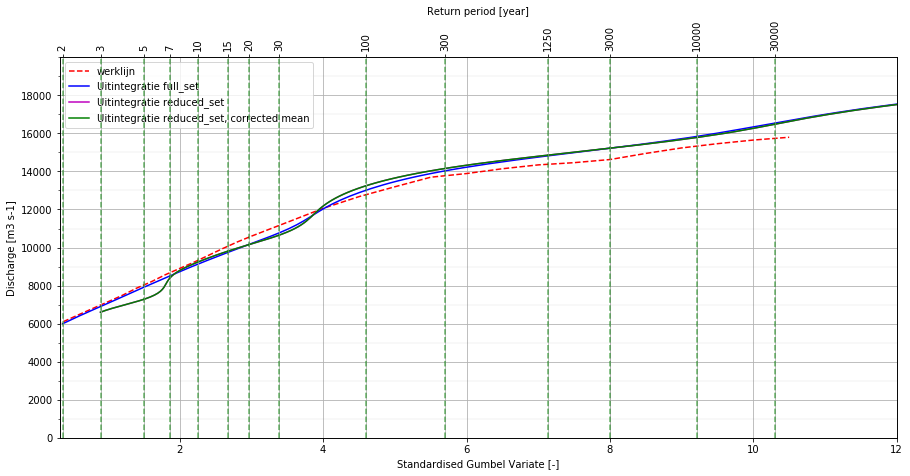

In [268]:
np_sgv_i = np.array(sgv_i)
np_alpha_i = np.array(alpha_i)
np_beta_i = np.array(beta_i)
np_AA_i = np.array(AA_i)
np_BB_i = np.array(BB_i)

fig, ax = plt.subplots(1,1)
ax.set_xlim(0.325,12)
ymax = 20000 
yrange = 2000
ax.set_ylim(0,ymax)

ax.plot(np_sgv_i,np_alpha_i/(np_alpha_i+np_beta_i)*(np_BB_i-np_AA_i)+np_AA_i,'r--',label="werklijn")
ax.plot(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],'b-',label="Uitintegratie full_set")
ax.plot(rijn_new['uitintegratie2']['sgv'],rijn_new['uitintegratie']['levels'],'m-',label="Uitintegratie reduced_set")
ax.plot(rijn_new['uitintegratie3']['sgv'],rijn_new['uitintegratie']['levels'],'g-',label="Uitintegratie reduced_set, corrected mean")

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax,ymax,yrange)
plt.savefig('plots//plot_03a.png', dpi=150, bbox_inches='tight')

In [274]:
for sgv, level in zip (rijn_new['uitintegratie2']['sgv'],rijn_new['uitintegratie']['levels']):
    sys.stdout.write("%15.8f %15.2f %15.4f\n"%(sgv, 1./(1.-np.exp(-np.exp(-sgv))), level))

            nan             nan       6000.0000
            nan             nan       6100.0000
            nan             nan       6200.0000
            nan             nan       6300.0000
            nan             nan       6400.0000
            nan             nan       6500.0000
     0.89346762            2.98       6600.0000
     0.96762648            3.16       6700.0000
     1.05291199            3.40       6800.0000
     1.14625103            3.67       6900.0000
     1.24360048            3.99       7000.0000
     1.34041434            4.34       7100.0000
     1.43222652            4.71       7200.0000
     1.51526186            5.07       7300.0000
     1.58693948            5.41       7400.0000
     1.64612998            5.70       7500.0000
     1.69310362            5.95       7600.0000
     1.72922642            6.15       7700.0000
     1.75654623            6.31       7800.0000
     1.77741153            6.43       7900.0000
     1.79420153            6.53       80

In [275]:
for distparset in rijn_parms_new3['distpar']:
    alpha, beta, AA, BB = distparset
    mean = alpha/(alpha+beta)*(BB-AA)+AA
    #sys.stdout.write("%15.2f "%(mean)+"%15.2f"%(mean))
    sys.stdout.write("%15.2f %15.8f %15.8f %15.2f %15.2f \n"%(mean,alpha,beta,AA-mean,BB-mean))

        6085.73     64.59973299    208.58221521        -2348.06         7581.51 
        6991.30     25.44289653     59.85493986        -2321.22         5460.72 
        8033.58   1147.95378101    871.13299070       -28024.31        21266.45 
        8689.25   1785.10063254   2096.57034744       -31520.51        37020.30 
        9322.70    350.50171003   1311.73784598        -9836.25        36811.75 
       10074.40    255.24614537   1138.44573124        -9126.66        40706.60 
       10553.04     24.47381925     27.24642597        -4326.91         4817.09 
       11158.94 -18166.61749893     87.82536100     -1269480.33        -6137.22 
       12779.87      6.25749726      6.19077231        -2939.89         2908.54 
       13774.25     20.35711263     11.09592330        -4926.06         2685.02 
       14374.71      6.32072319      6.86695383        -2485.30         2700.08 
       14629.07      8.59621660     28.20041255        -1968.34         6457.27 
       15329.78      7.34418

In [31]:
# Relevante herhaaltijden
# Tretlist = [2,5,10,20,30,100,300,1250,3000,10000,30000,100000,400000]
Tretlist = [2,5,10,20,30,100,300,1250,3000,10000,30000]

In [32]:
sgv_i = [estimate[0] for estimate in estimates] 
alpha_i = [estimate[1][0] for estimate in estimates] 
beta_i = [estimate[1][1] for estimate in estimates] 
AA_i = [estimate[1][2] for estimate in estimates] 
BB_i = [estimate[1][3] for estimate in estimates] 

np_sgv_i = np.array(sgv_i)
np_alpha_i = np.array(alpha_i)
np_beta_i = np.array(beta_i)
np_AA_i = np.array(AA_i)
np_BB_i = np.array(BB_i)

(41,)

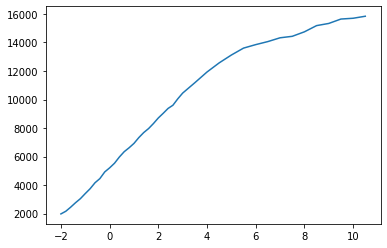

In [33]:
plt.plot(np_sgv_i,np_AA_i+np_alpha_i/(np_alpha_i+np_beta_i)*(np_BB_i-np_AA_i),'-')
#plt.plot(np_AA_i+np_alpha_i/(np_alpha_i+np_beta_i)*(np_BB_i-np_AA_i),'+')
np.shape(np_AA_i)

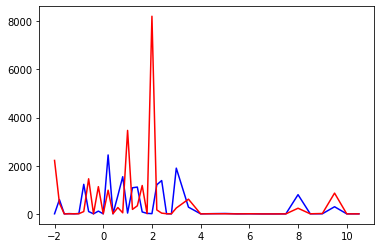

In [34]:
plt.plot(sgv_i,alpha_i,'b-',sgv_i,beta_i,'r-'); plt.show()

In [35]:
# Relevante herhaaltijden
# Tretlist = [2,5,10,20,30,100,300,1250,3000,10000,30000,100000,400000]
# Tretlist = [2,3,5,7,20,30,100,300,1250,3000,10000,30000]
Tretlist = [2,3,5,7,10,15,20,30,100,300,1250,3000,10000,30000]


In [36]:
#interpolate from the list of Beta parameters for a given set of return periods
interpol_beta = {}   # Summary of interpolation results for the beta-parameters
sgv_select = [-np.log(-np.log(1.-1./Tr)) for Tr in Tretlist]
interpol_beta['Herhaaltijd'] = np.array(Tretlist)
interpol_beta['alpha'] = np.array([int(interpolate(sgv_i,alpha_i,sgv)*1000.)/1000. for sgv in sgv_select])
interpol_beta['beta'] = np.array([int(interpolate(sgv_i,beta_i,sgv)*1000.)/1000. for sgv in sgv_select])
interpol_beta['AA'] = np.array([int(interpolate(sgv_i,AA_i,sgv)*1000.)/1000. for sgv in sgv_select])
interpol_beta['BB'] = np.array([int(interpolate(sgv_i,BB_i,sgv)*1000.)/1000. for sgv in sgv_select])
interpol_beta['mean'] = interpol_beta['alpha']/(interpol_beta['alpha']+interpol_beta['beta'])*(interpol_beta['BB']-interpol_beta['AA'])+interpol_beta['AA']
betapar_zip = zip(interpol_beta['alpha'],interpol_beta['beta'],interpol_beta['AA'],interpol_beta['BB'])
pct_025 = []
pct_500 = []
pct_975 = []
for alpha, beta, AA, BB in betapar_zip:
    pct_025.append(fb.beta_reverse(alpha,beta,AA,BB,0.025))
    pct_500.append(fb.beta_reverse(alpha,beta,AA,BB,0.500))
    pct_975.append(fb.beta_reverse(alpha,beta,AA,BB,0.975))

interpol_beta['pct_025'] = np.array([int (p*1000.)/1000. for p in pct_025])
interpol_beta['pct_500'] = np.array([int (p*1000.)/1000. for p in pct_500])
interpol_beta['pct_975'] = np.array([int (p*1000.)/1000. for p in pct_975])
df = pd.DataFrame(interpol_beta)
df.to_csv(path_or_buf='BetaParametersFit.csv', sep=';', decimal=',')
df

,Herhaaltijd,alpha,beta,AA,BB,mean,pct_025,pct_500,pct_975
0,2,414.869,172.315,-350.094,9463.836,6583.840380,6216.333,6586.143,6938.268
1,3,770.763,1804.005,-36565.503,137963.235,15680.094928,12619.432,15671.026,18792.285
2,5,599.687,758.794,-9908.417,46137.294,14832.366487,13357.815,14830.755,16316.070
3,7,20.221,2872.962,5015.217,480222.896,8336.532823,7053.244,8282.698,9925.531
4,10,1255.487,132.773,-73775.504,16436.483,7808.620676,6364.622,7826.137,9153.103
5,15,7.442,8.661,7419.684,12547.534,9789.519416,8618.783,9781.289,11005.923
6,20,1618.807,210.478,-66709.580,20741.553,10679.403269,9366.633,10691.671,11922.467
7,30,656.973,527.939,-22050.600,40132.612,12426.805358,10662.676,12428.710,14180.108
8,100,13.690,8.315,8069.162,15513.889,12700.759938,11164.317,12728.777,14080.677
9,300,5.476,4.505,11142.508,15633.143,13606.260856,12277.120,13621.411,14852.790


In [37]:
# Voer een uitintegratie uit voor de nieuwe resultaten
def cdfbeta(y,parms):
    return fb.beta_forward(parms[0],parms[1],parms[2],parms[3],y)


def outintegrate(parms, levels, distfun):
    # based on a numerical integral over q probabilities
    # this works if we have an ordered set (in terms of reference q) in parms, each with its non-exceedance probability
    # each record in parms consists of a tuple of parameters AND an associated non-exceedance probability
    # has to be ordered on reference Q (that also means ordered by non-exceedance probability) 
    nx = len(parms['F'])
    nl = len(levels)
    cdf = np.array([0.0]*nl)
    H = parms['F']
    wtsum = 0.0
#   for i in range(nx):
    for i in tqdm(list(range(nx))):
        if i==0:
            wt = 0.5*(H[0]+H[1])
        elif i==nx-1:
            wt = 1.-0.5*(H[nx-1]+H[nx-2])
        else:
            wt = 0.5*(H[i+1]-H[i-1])
        wtsum = wtsum + wt
        distribution = all_distributions(distfun, parms['distpar'][i], levels)
        cdf += distribution * wt
    return cdf

rijn_new['uitintegratie2'] = {}
np_yy = np.array([est[0] for est in estimates])
nsel = len(interpol_beta['alpha'])
distpar_select=[]
F_select=[]
for i in range(nsel):
    if not any(np.isnan([interpol_beta['alpha'][i],interpol_beta['beta'][i],interpol_beta['AA'][i],interpol_beta['BB'][i]])):
        distpar_select.append([interpol_beta['alpha'][i],interpol_beta['beta'][i],interpol_beta['AA'][i],interpol_beta['BB'][i]])
        F_select.append(np.exp(-np.exp(-np.array(sgv_select[i]))))                          
rijn_parms_new2 = {'distpar' : distpar_select,
                  'F' : F_select}
rijn_new['uitintegratie2']['levels'] = np.array(list(range(6000,21000,100)))
rijn_cdf_new2 = outintegrate(rijn_parms_new2, rijn_new['uitintegratie2']['levels'] , cdfbeta)
rijn_new['uitintegratie2']['sgv'] = -np.log(-np.log(rijn_cdf_new2))

In [38]:
# Leid verwachting, variantie, scheefheid, kurtosis en het tweezijdig 95% betrouwbaarheidsinterval af uit de beta paerameters
yy = []
pct_025 = []
pct_975 = []
pct_500 = []
meanlist = []
varlist = []
skewlist = []
kurtlist = []

for est in estimates:
    yy.append(est[0])
    alpha_fit=est[1][0]
    beta_fit=est[1][1]
    AA_fit=est[1][2]
    BB_fit=est[1][3]
    pct_025.append(fb.beta_reverse(alpha_fit,beta_fit,AA_fit,BB_fit,0.025))
    pct_500.append(fb.beta_reverse(alpha_fit,beta_fit,AA_fit,BB_fit,0.500))
    pct_975.append(fb.beta_reverse(alpha_fit,beta_fit,AA_fit,BB_fit,0.975))
    mean, var, skew, kurt = fb.BetaMoments(alpha_fit,beta_fit,AA_fit,BB_fit)
    meanlist.append(mean)
    varlist.append(var)
    skewlist.append(skew)
    kurtlist.append(kurt)
np_yy = np.array(yy)
np_pct025 = np.array(pct_025)
np_pct500 = np.array(pct_500)
np_pct975 = np.array(pct_975)
np_mean = np.array(meanlist)
np_var = np.array(varlist)
np_skew = np.array(skewlist)
np_kurt = np.array(kurtlist)


In [39]:
# Voer een uitintegratie uit voor de nieuwe resultaten
def cdfbeta(y,parms):
    return fb.beta_forward(parms[0],parms[1],parms[2],parms[3],y)

rijn_new['uitintegratie'] = {}
np_yy = np.array([est[0] for est in estimates])
rijn_parms_new = {'distpar' : [est[1] for est in estimates],
                  'F' : np.exp(-np.exp(-np_yy))}
rijn_new['uitintegratie']['levels'] = np.array(list(range(6000,21000,100)))
rijn_cdf_new = outintegrate(rijn_parms_new, rijn_new['uitintegratie']['levels'] , cdfbeta)
rijn_new['uitintegratie']['sgv'] = -np.log(-np.log(rijn_cdf_new))

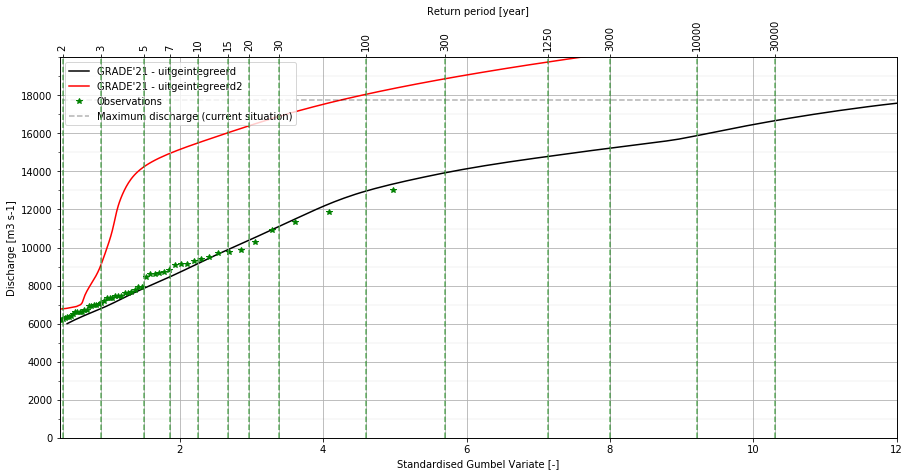

In [40]:
#plot nieuw versus observations met 
fig, ax = plt.subplots(1,1)
ax.set_xlim(0.325,12)
ymax = 20000 
yrange = 2000
ax.set_ylim(0,ymax)

#ax.plot(np_yy,np_mean,'b-',label="GRADE'21")
#ax.plot(np_yy,np_pct025,'b--')
#ax.plot(np_yy,np_pct975,'b--')
ax.plot(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],'k-',label="GRADE'21 - uitgeintegreerd")
ax.plot(rijn_new['uitintegratie2']['sgv'],rijn_new['uitintegratie2']['levels'],'r-',label="GRADE'21 - uitgeintegreerd2")
ax.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observations")
ax.plot([-1,13],[17750,17750],'k--',alpha=0.3, label="Maximum discharge (current situation)")



ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax,ymax,yrange)
plt.savefig('plots//plot_03a.png', dpi=150, bbox_inches='tight')

In [53]:
# Schrijf uitgeïntegreerde werklijn naar file
with open("werklijn_uitgeintegreerd.txt","w") as ff:
    for sgv, level in zip(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels']):
        sys.stdout.write("%12.4e %12.4e %12.4e \n"%((1./(1.-exp(-exp(-sgv)))),sgv,level))
        ff.write("%12.4e %12.4e %12.4e \n"%((1./(1.-exp(-exp(-sgv)))),sgv,level))

  2.0891e+00   4.2864e-01   6.0000e+03 
  2.1694e+00   4.8133e-01   6.1000e+03 
  2.2574e+00   5.3583e-01   6.2000e+03 
  2.3553e+00   5.9306e-01   6.3000e+03 
  2.4650e+00   6.5327e-01   6.4000e+03 
  2.5867e+00   7.1595e-01   6.5000e+03 
  2.7196e+00   7.8002e-01   6.6000e+03 
  2.8616e+00   8.4410e-01   6.7000e+03 
  3.0101e+00   9.0688e-01   6.8000e+03 
  3.1626e+00   9.6736e-01   6.9000e+03 
  3.3172e+00   1.0251e+00   7.0000e+03 
  3.4737e+00   1.0803e+00   7.1000e+03 
  3.6334e+00   1.1335e+00   7.2000e+03 
  3.7994e+00   1.1860e+00   7.3000e+03 
  3.9757e+00   1.2388e+00   7.4000e+03 
  4.1663e+00   1.2929e+00   7.5000e+03 
  4.3743e+00   1.3488e+00   7.6000e+03 
  4.6018e+00   1.4064e+00   7.7000e+03 
  4.8495e+00   1.4656e+00   7.8000e+03 
  5.1173e+00   1.5259e+00   7.9000e+03 
  5.4041e+00   1.5866e+00   8.0000e+03 
  5.7091e+00   1.6473e+00   8.1000e+03 
  6.0315e+00   1.7077e+00   8.2000e+03 
  6.3708e+00   1.7676e+00   8.3000e+03 
  6.7268e+00   1.8267e+00   8.4000e+03 


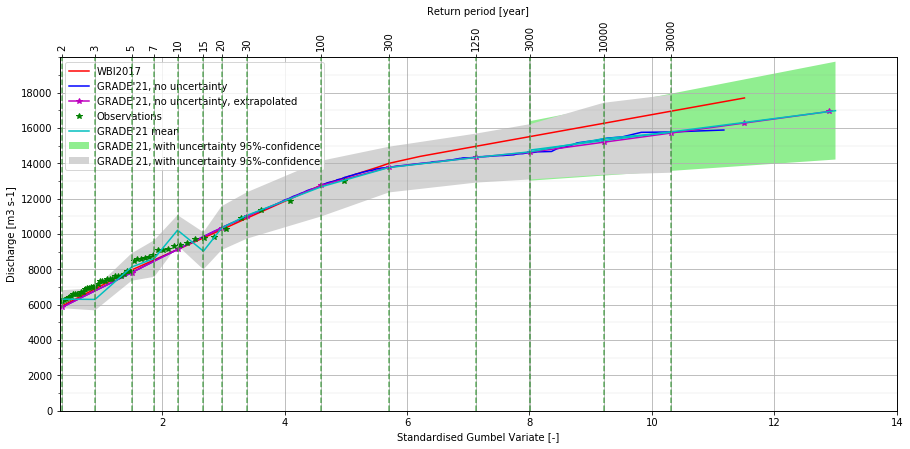

In [204]:
#plot oud versus observations
fig, ax = plt.subplots(1,1)
ax.set_xlim(0.325,14)
ymax = 20000 
yrange = 2000
ax.set_ylim(0,ymax)



# boven en ondergrens lineair fitten tegen de standardised gumbel variate (logaritmische extrapolatie)
npnt = 5
sgv_extrap=np.array([8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13])

not_a_nan = ~np.isnan(interpol_beta['pct_025'])
x = np.array(sgv_select)[not_a_nan]
y = interpol_beta['pct_025'][not_a_nan]
c_025 = linfit(x[-npnt:],y[-npnt:])
interpol_beta['pct_025w'] = c_025[0]*sgv_extrap+c_025[1]

not_a_nan = ~np.isnan(interpol_beta['pct_975'])
x = np.array(sgv_select)[not_a_nan]
y = interpol_beta['pct_975'][not_a_nan]
c_975 = linfit(x[-npnt:],y[-npnt:])
interpol_beta['pct_975w'] = c_975[0]*sgv_extrap+c_975[1]

not_a_nan = ~np.isnan(interpol_beta['mean'])
x = np.array(sgv_select)[not_a_nan]
y = interpol_beta['mean'][not_a_nan]
c_mean = linfit(x[-npnt:],y[-npnt:])
interpol_beta['mean_w'] = c_mean[0]*sgv_extrap+c_mean[1]

ax.fill_between(sgv_extrap,interpol_beta['pct_025w'],interpol_beta['pct_975w'],facecolor='lightgreen',label="GRADE 21, with uncertainty 95%-confidence")
ax.fill_between(sgv_select,interpol_beta['pct_025'],interpol_beta['pct_975'],facecolor='lightgray',label="GRADE 21, with uncertainty 95%-confidence")
ax.plot(rijn_old['sgv'],rijn_old['mu'],'r-',label="WBI2017")
ax.plot(rijn_new['sgv'],rijn_new['mu_sbk'],'b-',label="GRADE'21, no uncertainty")
ax.plot(rijn_new['sgv_select'],rijn_new['mu_sbk_select'],'m-*',label="GRADE'21, no uncertainty, extrapolated")
ax.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observations")
ax.plot(sgv_select,interpol_beta['mean'],'c-',label="GRADE'21 mean")
ax.plot(sgv_extrap,interpol_beta['mean_w'],'c-')



ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,6.5)
ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax,ymax,yrange)
plt.savefig('plots//plot_01.png', dpi=150, bbox_inches='tight')


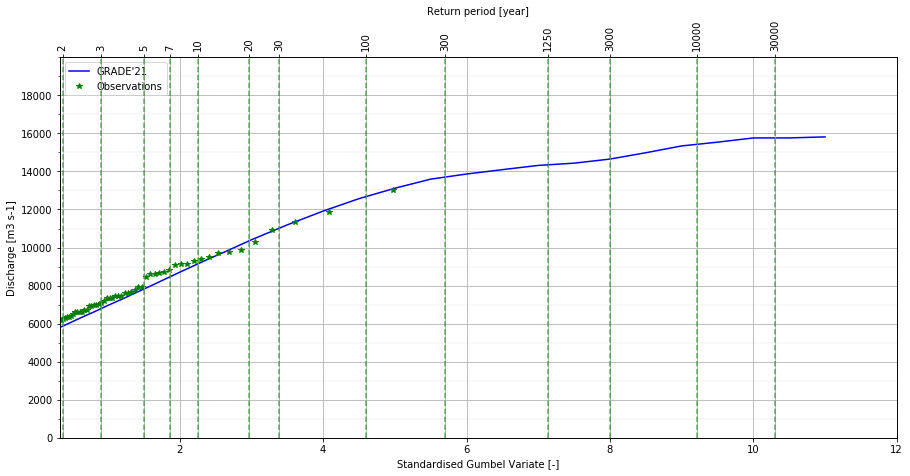

In [161]:
#plot oud versus observations
fig, ax = plt.subplots(1,1)
ax.set_xlim(0.325,12)
ymax = 20000 
yrange = 2000
ax.set_ylim(0,ymax)

#ax.plot(rijn_old['sgv'],rijn_old['mu'],'r-',label="WBI2017")
#ax.plot(rijn_new['sgv'],regression_2018(rijn_new['mu']),'m-',label="GRADE'21")
ax.plot(np_yy,np_mean,'b-',label="GRADE'21")
ax.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observations")

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax,ymax,yrange)
plt.savefig('plots//plot_03c.png', dpi=150, bbox_inches='tight')

In [ ]:
#plot oud en nieuw uitgeïntegreerd versus observations
fig, ax = plt.subplots(1,1)
ax.set_xlim(0.325,12)
ymax = 20000 
yrange = 2000
ax.set_ylim(0,ymax)

ax.plot(rijn_old['uitintegratie']['sgv'],rijn_old['uitintegratie']['levels'],'r-',label="WBI2017 - processed uncertainties")
ax.plot(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],'b-',label="GRADE'21 - processed uncertainties")
ax.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observations")

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax,ymax,yrange)
plt.savefig('plots//plot_04.png', dpi=150, bbox_inches='tight')

In [ ]:
#fit een functioneel voorschrift uit de berekende punten op de manier van Henk vd Boogaerd

# plot a piece-wise linear
x = [0,   4.7,  8,    12,   20     ]
y = [5250,13500,14800,17400,17400  ]

fig, ax = plt.subplots(1,1)
ax.set_xlim(0.325,12)
ymax = 20000 
yrange = 2000
ax.set_ylim(0,ymax)

ax.plot(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],'b*',label="GRADE'21 - processed uncertainties")
ax.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observations")
ax.plot(x,y,'r-+',label='Linear fit')

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax,ymax,yrange)
plt.savefig('plots//plot_05.png', dpi=150, bbox_inches='tight')




<H2> Gedeeltelijk lineaire benadering met exponentiële overgangen</H2>
Dit is een generalisatie van de uitdrukking die Henk vd Boogaard gebruikt voor <tt>regressie_2018</tt>, namelijk:
$$
y(x)\,=\,
C\,+r_1 x
+ \sum\limits_{i=2}^n \left(r_i-r_{i-1}\right)\,\log\left(1\,+\,\exp\left(\frac{x-\mu_{i-1}}{\sigma_{i-1}}\right)\right)\,\,,
$$
geïmplementeerd in de onderstaande functie <tt>pwlin</tt>.
De knikpunten (op de horizontale as) bevinden zichop de $\mu_i$, de helling van de stukken is voorgeschreven door de $r_i$ op het interval $\left(\mu_{i-1},\mu_i\right)$, $C$ is een offset en de $\sigma_i$ bepaalt de scherpte van het knikpunt bij $\mu_i$, m.a.w. hoe glad de overgang verloopt. Zo kan in termen van een beperkte set parameters bovenstaande curve redelijk beschreven worden. Er zijn grofweg vier intervallen te onderscheiden, dus vier hellingen en drie knikpunten.

Gegeven een set knikpunten $\left(x_i,y_i\right)$, kan bepaald worden:
<ul>
    <li>$r_i=\left(y_i-y_{i-1}\right)/\left(x_i-x_{i-1}\right)$</li>
    <li>$\mu_i=r_i$</li>
    <li>$C=y_1-r_1x_1$</li>
</ul>
De $\sigma_i$ moeten nog naar smaak gekozen worden en hangen samen met hoe dicht het knikpunt benaderd moet worden.
Omdat de knikpunten zelf geen onderdeel van de data zijn en ook omdat de curve een beetje glad moet blijven, hoeven de $\sigma_i$ in dit geval niet heel klein te zijn.
Dit is geïmplementeerd in de onderstaande functie <tt>pwlin_points</tt>. Dan zijn er dus 5 punten nodig in dit geval.

In [ ]:
#Piecewise linear with exonential smooth transitions
#Dit is de aanpak van Henk vd Boogaard, maar dan generieker:

MAX_EXP = 700.     # max argument of the exponent function
def pwlin(x,r,mu,sigma):
    x_ = []
    for value in x:
        y = r[0] + r[1]*value
        for i in range(1,len(mu)):
            z = (value-mu[i])/sigma[i]
            if (z<=MAX_EXP):
                a = np.log(1+np.exp(z))
            else:
                a = z
            y += (r[i+1]-r[i])*sigma[i]*a
        x_.append(y)
    return x_

def pwlin_points(x,xs,ys,sigma):
    r=np.array([ys[0] - ((ys[1]-ys[0])/(xs[1]-xs[0]))*xs[0]])
    for i in range(1,len(xs)):
        r = np.append(r, (ys[i]-ys[i-1])/(xs[i]-xs[i-1]))
    print (r)
    return pwlin(x,r,xs[:-1],sigma)    

In [73]:
def benadering(sgv):
    xss = np.array([0,   4.7,  8,    12.0,   20 ])
    yss = np.array([5250,13500,14800, 17300, 17400])
    sgm = np.array([np.nan,0.3,0.1,0.5,0.1])
    return pwlin_points(sgv,xss,yss,sgm)

# plot benadering
sgv = np.linspace(0, 13, num=200)
qq = benadering(sgv)

fig, ax = plt.subplots(1,1)
ax.set_xlim(0.325,12)
ymax = 20000 
yrange = 2000
ax.set_ylim(0,ymax)

ax.plot(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],'k-',label="GRADE'21 - processed uncertainties")
ax.plot(sgv,qq,'r-',label='Discharge statistics (as function)')
ax.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observations")

ax.plot(rijn_old['sgv'],rijn_old['mu'],'c-',label="WBI2017")
ax.plot(rijn_new['sgv'],rijn_new['mu_sbk'],'b-',label="GRADE'21")
ax.plot(rijn_new['sgv_select'],rijn_new['mu_sbk_select'],'m-*',label="GRADE'21, Weissman")


ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax,ymax,yrange)
plt.savefig('plots//plot_06.png', dpi=150, bbox_inches='tight')


NameError: name 'pwlin_points' is not defined

<h2>Scenarios</h2>

In [ ]:
infile =r"read_Qmax_sums_results.csv"

df = pd.read_csv(infile, sep=';', index_col=0)
df.dropna(inplace=True)

ref = df.loc[['Sum113']]

scenarios = ['Sum101','Sum102','Sum103',
             'Sum104','Sum105','Sum106',
             'Sum107','Sum108','Sum109',
             'Sum110','Sum111','Sum112',]

x_start = pd.Series(np.arange(250,12500,250))
y_start = pd.Series(np.arange(250,12500,250))

func = []
for scenario in scenarios:
    fig1, ax1 = plt.subplots(figsize=(12,6))
    scenA = df.loc[[scenario]]
    
    df2 = pd.concat([ref, scenA], axis=0).T
    x = df2['Sum113'].sort_values()
    y = df2[scenario].sort_values()
    
    x = pd.concat([x_start, x], axis=0)
    x.reindex()
    y = pd.concat([y_start, y], axis=0)
    
    z = np.polyfit(x, y, 3)
    f = np.poly1d(z)
    func.append(f)
    
    # calculate new x's and y's
    x_new = np.linspace(x.iloc[0], x.iloc[-1], 50)
    y_new = f(x_new)
    
    ax1.plot(x,y, 'ro', label=scenario)
    ax1.plot(x_new,y_new, 'r', label=scenario + "_fit")

    ax1.plot([0,20000],[0,20000], 'k--')  
    ax1.set_xlim(10000,20000)
    ax1.set_ylim(10000,)
    plt.legend()
    # plt.savefig(f"{scenario}_linfit.png", dpi=150, bbox_inches='tight')

In [ ]:
fig1, ax1 = plt.subplots(figsize=(12,6))

colors = ['blue','orange','red']
for scenario, color in zip(scenarios[0:3], colors):
    
    scenA = df.loc[[scenario]]
    
    df2 = pd.concat([ref, scenA], axis=0).T
    x = df2['Sum113'].sort_values()
    y = df2[scenario].sort_values()
    
    x = pd.concat([x_start, x], axis=0)
    x.reindex()
    y = pd.concat([y_start, y], axis=0)
    
    z = np.polyfit(x, y, 5)
    f = np.poly1d(z)
    func.append(f)
    
    # calculate new x's and y's
    x_new = np.linspace(x.iloc[0], x.iloc[-1], 50)
    y_new = f(x_new)
    
    ax1.scatter(x,y, marker = 'o', color=color, label=scenario)
    ax1.plot(x_new,y_new, color=color, label=scenario + "_fit")

ax1.plot([0,20000],[0,20000], 'k--')  
ax1.set_xlim(10000,20000)
# ax1.set_ylim(13500,20000)
# ax1.set_xlim(0,20000)
ax1.set_ylim(10000,)
plt.legend()
#plt.savefig(f"{scenario}_allinone.png", dpi=150, bbox_inches='tight')

In [ ]:
#plot oud versus observations
fig, ax = plt.subplots(1,1)
ax.set_xlim(0.325,12)
ymax = 20000 
yrange = 500
ax.set_ylim(0,ymax)

ax.set_xlim(8,12)
ax.set_ylim(14000,17000)

scenarios = ['Sum101','Sum102','Sum103']

for scenario in scenarios:
#scenario = 'Sum102'

    scenA = df.loc[[scenario]]

    df2['Sum113']

    df2 = pd.concat([ref, scenA], axis=0).T
    x = df2['Sum113'].sort_values()
    y = df2[scenario].sort_values()

    x = pd.concat([x_start, x], axis=0)
    x.reindex()
    y = pd.concat([y_start, y], axis=0)

    z = np.polyfit(x, y, 5)
    f = np.poly1d(z)
    func.append(f)

    np_mean_new = f(np_mean)

    ax.plot(np_yy[np_mean_new>13000],np_mean_new[np_mean_new>13000],linestyle='--',label="GRADE'21 - %s" %(scenario))

ax.plot(np_yy,np_mean,'b-',label="GRADE'21")
ax.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observations")

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax,ymax,yrange)
plt.savefig('plots//plot_10_all_zoom.png', dpi=150, bbox_inches='tight')


<hr>
<hr>

In [4]:
# Lees oude werklijn
column_Tret  = 8
column_Qref  = 9
column_Sigma = 10

with open('./oude_getallen.csv',"r") as fnin:
    sgv_list = []
    mu_list = []
    sigma_list = []
    while True:
        line = fnin.readline()
        if not line:
            break
        if line[0] in '#*':
            continue
        columns = line.strip().split(';')
        Tret = float(columns[column_Tret-1])
        mu_value = float(columns[column_Qref-1])
        sigma_value = float(columns[column_Sigma-1])
        sgv_list.append(-np.log(-np.log(1.-1./Tret)))
        mu_list.append(mu_value)
        sigma_list.append(sigma_value)
nx_old = len(sgv_list)        
np_sgv_old = np.array(sgv_list)        
np_qref_old = np.array(mu_list)
np_sigma_old = np.array(sigma_list)
rijn_old={'sgv':np.array(sgv_list),'mu':np.array(mu_list),'sigma':np.array(sigma_list)}